In [3]:
import numpy as np
import shapely
import geopandas as gpd
from cartopy.feature import NaturalEarthFeature
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, confusion_matrix


def justify(a, invalid_val=np.nan, axis=1, side='right'):
    """
    Justifies a 2D array
    Courtesy: https://stackoverflow.com/questions/44558215/python-justifying-numpy-array/44559180#44559180

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """
    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val)
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

def layers(var, depth, ax=None, colormap='viridis', plot_soil=True,
           plot_snow=True, variable_range=None, add_colorbar=True,
           line_kwargs={}, cbar_kwargs={}):
    """
    Makes a layers plot. Example usage:

    ::

        import pysumma.plotting as psp
        time_range = slice('10-29-2000', '04-30-2001')
        depth    = ds.isel(hru=0).sel(time=time_range)['iLayerHeight']
        temp     = ds.isel(hru=0).sel(time=time_range)['mLayerTemp']
        psp.layers(temp, depth)

    Parameters
    ----------
    var: xr.DataArray
        The variable holding the data to plot.
        Typically begins with ``mLayer``.
    depth: xr.DataArray
        The variable defining the depths of the interfaces
        of each layer. Typically should be ``iLayerHeight``
    ax: Axes
        The axis to plot on. If none is given, a new axis
        will be created
    colormap: string, default='viridis'
        The colormap to use
    plot_soil: boolean, default=True
        Whether to plot the soil domain
    plot_snow: boolean, default=True
        Whether to plot the snow domain
    variable_range: List[float], default=variable range
        The range of numerical values to use. Must be two numbers.
    add_colorbar: boolean, default=True
        Whether to add a colorbar
    line_kwargs: Dict, default={}
        Keyword arguments to pass to ax.vlines.
        These draw the individual layers.
    cbar_kwargs: Dict, default={}
        Keyword arguments to draw the colorbar.
        They are passed directly to plt.colorbar.
    """
    # Preprocess the data
    vmask = var != -9999
    dmask = depth != -9999
    depth.values = justify(depth.where(dmask).values)
    var.values = justify(var.where(vmask).values)
    lo_depth = depth.where(depth > 0).T
    hi_depth = depth.where(depth < 0).T
    if plot_soil and not plot_snow:
        var = var.where((depth > 0).values[:,:-1]).T
    elif plot_snow and not plot_soil:
        var = var.where((depth < 0).values[:,:-1]).T
    else:
        var = var.T
    time = depth.time.values

    # Map colors to full range of data
    if variable_range is not None:
        assert len(variable_range) == 2, 'variable_range must have 2 values!'
        norm = plt.Normalize(variable_range[0], variable_range[1])
    else:
        norm = plt.Normalize(np.nanmin(var), np.nanmax(var))
    cmap = mpl.cm.get_cmap(colormap)
    rgba = cmap(norm(var))

    # Create axes if needed
    if not ax:
        fig, ax = plt.subplots(figsize=(18,8))

    # Plot soil layers - need to reverse because we plot bottom down
    if plot_soil:
        for l in lo_depth.ifcToto.values[:-1][::-1]:
            y = lo_depth[l]
            y[np.isnan(y)] = 0
            ax.vlines(time, ymin=-y, ymax=0, color=rgba[l], **line_kwargs)

    # Plot snow layers - plot top down
    if plot_snow:
        for l in hi_depth.ifcToto.values[:-1]:
            y = hi_depth[l]
            y[np.isnan(y)] = 0
            if (y != 0).any():
                ax.vlines(time, ymin=0, ymax=-y, color=rgba[l], **line_kwargs)

    # Add the colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(var.values.flatten())
    try:
        label = var.long_name
    except:
        label = var.name
    if 'label' not in cbar_kwargs.keys():
        cbar_kwargs['label'] = label
    if 'ax' not in cbar_kwargs.keys():
        cbar_kwargs['ax'] = ax
    if add_colorbar:
        plt.gcf().colorbar(mappable, **cbar_kwargs)
    return ax, mappable

In [19]:
summa = xr.open_dataset('/home/cdalden/summa_setup/model/output/output_harts_current_WY24_timestep.nc')

In [20]:
depth = summa.isel(hru=0)['mLayerHeight']
idepth = summa.isel(hru=0)['iLayerHeight']
var = summa.isel(hru=0)['mLayerVolFracWat']
temp = summa.isel(hru=0)['mLayerTemp']
vmask = var != -9999
dmask = depth != -9999
idmask = idepth != -9999
tmask = temp != -9999
depth.values = justify(depth.where(dmask).values)
idepth.values = justify(idepth.where(idmask).values)
var.values = justify(var.where(vmask).values)
temp.values = justify(temp.where(tmask).values)


# Filter var where the average is less than 273.05
# Calculate the average at all layers
average_temp = temp.mean(dim='midToto')

# Filter var where the average is less than 273.15
filtered_var = var.where(average_temp < 273)

# Calculate the vertical derivative
derivative = filtered_var.diff(dim='midToto')

# Initialize the list to store counts
counts = []

# Loop over the 'time' dimension within the specified range
for t in var.time.values[1464:4393]:
    # Select the derivative for the current timestep
    derivative_t = derivative.sel(time=t)

    # Calculate the running average over 3 layers
    running_avg = derivative_t.rolling(midToto=3, center=False).sum()

    # Filter values that are greater than or equal to 0.2 or less than or equal to -0.2
    threshold = 0.15
    filtered = running_avg.where((running_avg >= threshold) | (running_avg <= -threshold))

    # Count the number of layers with at least one such value
    count = np.isfinite(filtered).sum().values

    # Append the count to the list
    counts.append(count)

# Convert the list to a numpy array
counts = np.array(counts)

crust_days = counts.sum() / 24
mean_crusts = counts.mean()

# binary crust metric
crusts_binary = np.where(counts > 0, 1, 0).sum()

# Calculate '-summa['iLayerHeight'].isel(ifcToto=nSnow)'
nSnow = summa['nSnow'].values[0] # assuming 'nSnow' is a variable in 'summa'
hs = -summa['iLayerHeight'].isel(ifcToto=nSnow)

# Apply the condition 'layer_height > 0' and sum the result
snow_on = (hs > 0).sum()

# Apply the conditions and count the number of timesteps where both conditions are true
isothermal_days = ((hs > 0) & (average_temp > 273.15)).sum().item()

In [21]:
print('number of crust timesteps: ' + str(crusts_binary/24))
print('number of snow covered days: ' + str(snow_on/24))
print('number of isothermal days: ' + str(((isothermal_days/snow_on))))

number of crust timesteps: 23.75
number of snow covered days: <xarray.DataArray 'iLayerHeight' ()>
array(256.20833333)
number of isothermal days: <xarray.DataArray 'iLayerHeight' ()>
array(0.16653114)


In [ ]:
rho_df = filtered_var.squeeze().to_pandas()
depth_df = -depth.squeeze().to_pandas()
# plt.plot(depth_df, 'o')

In [ ]:
# # Calculate the maximum value at each timestep minus 1
# max_minus_one = depth_df.max(axis=1) - 1

# # Create a mask where all cells are True where the value of the cell is greater than the (max value at that timestep - 1)
# mask = depth_df.gt(max_minus_one, axis=0)


# # Apply the mask to 'rho_df'
# rho_df_masked = rho_df.where(combined_mask)
# depth_df_masked = depth_df.where(combined_mask)

In [ ]:
# plt.plot(max_minus_one, 'o')

In [ ]:
# plt.plot(depth_df_masked, 'o')

#### Create table to compare to JS pits

In [ ]:
df = pd.DataFrame({
    'crusts_binary': crusts_binary
}, index=var.time.values)

# Resample to daily data
df_daily = df.resample('D').max()

# Now df_daily is a DataFrame with daily data where the day gets a 1 if any hour was a 1 and a 0 if no hours were >0

# df_daily

ValueError: Length of values (2929) does not match length of index (8745)

In [ ]:
# Set the maximum number of rows to display to None, which means display all rows
pd.set_option('display.max_rows', None)



### Read in JS obs to compare

In [ ]:
wsdot = pd.read_excel('/home/cdalden/summa_setup/analysis/Daily_Obs_WSDOT-Snoq_23_24.xlsx')



In [ ]:
# Add a new column 'new_column' to the DataFrame
wsdot['crust_binary'] = wsdot['Strat'].str.contains('K|P').astype(int)
# wsdot['crust_binary'] = wsdot['Strat'].str.contains('K').astype(int)


# Convert the 'Date' column to datetime
wsdot['Date'] = pd.to_datetime(wsdot['Date'])

# Set the 'Date' column as the index
wsdot.set_index('Date', inplace=True)

### Create confusion matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


In [ ]:
# Group by 'Date' and take the maximum 'crust_binary' for each date
wsdot_binary = wsdot.groupby('Date')['crust_binary'].max()

# Add 'obs_crusts_binary' to 'df_daily'
df_daily['obs_crusts_binary'] = wsdot_binary

In [ ]:
# Fill NaN values with 0
df_daily['obs_crusts_binary'].fillna(0, inplace=True)

# Convert 'obs_crusts_binary' to integer
df_daily['obs_crusts_binary'] = df_daily['obs_crusts_binary'].astype(int)

/tmp/ipykernel_24310/1711590603.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_daily['obs_crusts_binary'].fillna(0, inplace=True)


In [ ]:
# Filter 'df_daily' to between December 1, 2023 and March 31, 2024
df_daily_short = df_daily[(df_daily.index >= '2023-12-01') & (df_daily.index <= '2024-03-31')]

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(df_daily_short['crusts_binary'], df_daily_short['obs_crusts_binary'])
print(cf_matrix)

f1 = f1_score(df_daily_short['crusts_binary'], df_daily_short['obs_crusts_binary'])
print(f1)

ba_score = balanced_accuracy_score(df_daily_short['crusts_binary'], df_daily_short['obs_crusts_binary'])
print(ba_score)

[[ 7 14]
 [10 91]]
0.883495145631068
0.6171617161716172


### Plot with seaborn 
plot labels should be correct now

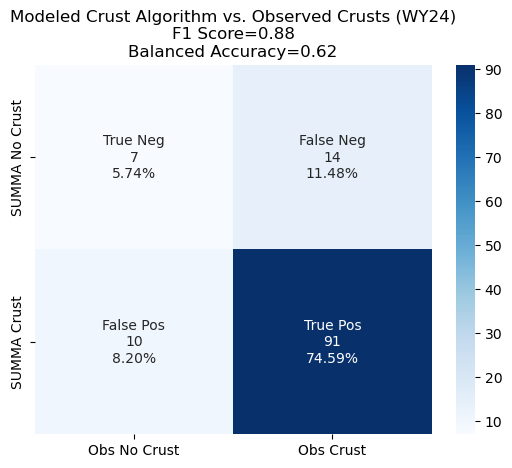

In [ ]:
group_names = ['True Neg','False Neg','False Pos','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Label the ticks
ax.set_xticklabels(['Obs No Crust', 'Obs Crust'])
ax.set_yticklabels(['SUMMA No Crust', 'SUMMA Crust'])

ax.set_title(f'Modeled Crust Algorithm vs. Observed Crusts (WY24)\nF1 Score={f1:.2f}\nBalanced Accuracy={ba_score:.2f}')

plt.savefig('./figures/confusion_matrix_WY24.png', dpi=300)

### Create other stats for batch post processing

In [ ]:
# filter for layers within top 1m
max_depth = summa.isel(hru=0)['iLayerHeight'].max(dim='ifcToto') - 1
filtered_var = filtered_var.where(summa.isel(hru=0)['iLayerHeight'] > max_depth)

In [ ]:
summa.isel(hru=0)['iLayerHeight'].max(dim='ifcToto')

<xarray.DataArray 'iLayerHeight' (time: 8049)>
array([5., 5., 5., ..., 5., 5., 5.])
Coordinates:
  * time     (time) datetime64[ns] 2023-10-01 ... 2024-08-31T08:00:00.000013312
    hru      int64 1001

In [ ]:
nSnow = summa['nSnow'].values[0] # assuming 'nSnow' is a variable in 'summa'

# plt.ylim(0,5)

### Add snow on days metric

In [ ]:
# Calculate '-summa['iLayerHeight'].isel(ifcToto=nSnow)'
hs = -summa['iLayerHeight'].isel(ifcToto=nSnow)

# Apply the condition 'layer_height > 0' and sum the result
snow_on = (hs > 0).sum()

## Create binary plot for hits/misses with the density plots

In [ ]:
# transpose daily binary data
df_daily_short_T = df_daily_short.T
df_daily_T = df_daily.T

# Create a mask for dates not between December 1 and March 31
mask = (df_daily.index.month < 12) & (df_daily.index.month > 3)

df_daily_masked = df_daily

# Set all values to 0 if not between December 1 and March 31
df_daily_masked.loc[mask] = 0

df_daily_masked_T = df_daily_masked.T


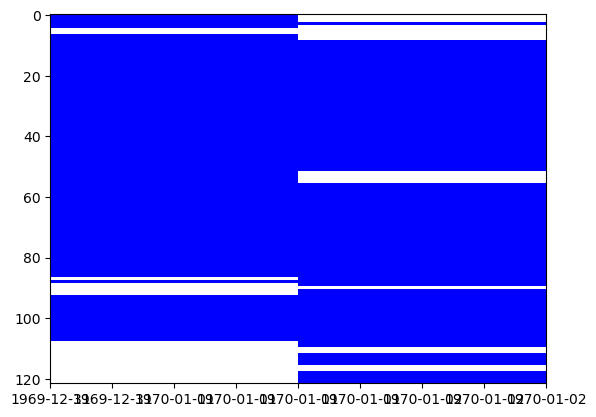

In [ ]:
import matplotlib.colors as colors
import matplotlib.dates as mdates


# Create a colormap where 0 is white and 1 is blue
cmap = colors.ListedColormap(['white', 'blue'])

# Create a colormap where 0 is white and 1 is blue
cmap = colors.ListedColormap(['white', 'blue'])

# Convert the index to a DatetimeIndex
df_daily_short.index = pd.to_datetime(df_daily_short.index)

# Convert the DatetimeIndex to a list of Python datetime objects
df_daily_short.index = df_daily_short.index.to_pydatetime()

# Create the plot
fig, ax = plt.subplots()
cax = ax.imshow(df_daily_short, aspect='auto', cmap=cmap, interpolation='none')

# Format the x-axis as dates
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

NameError: name 'var' is not defined

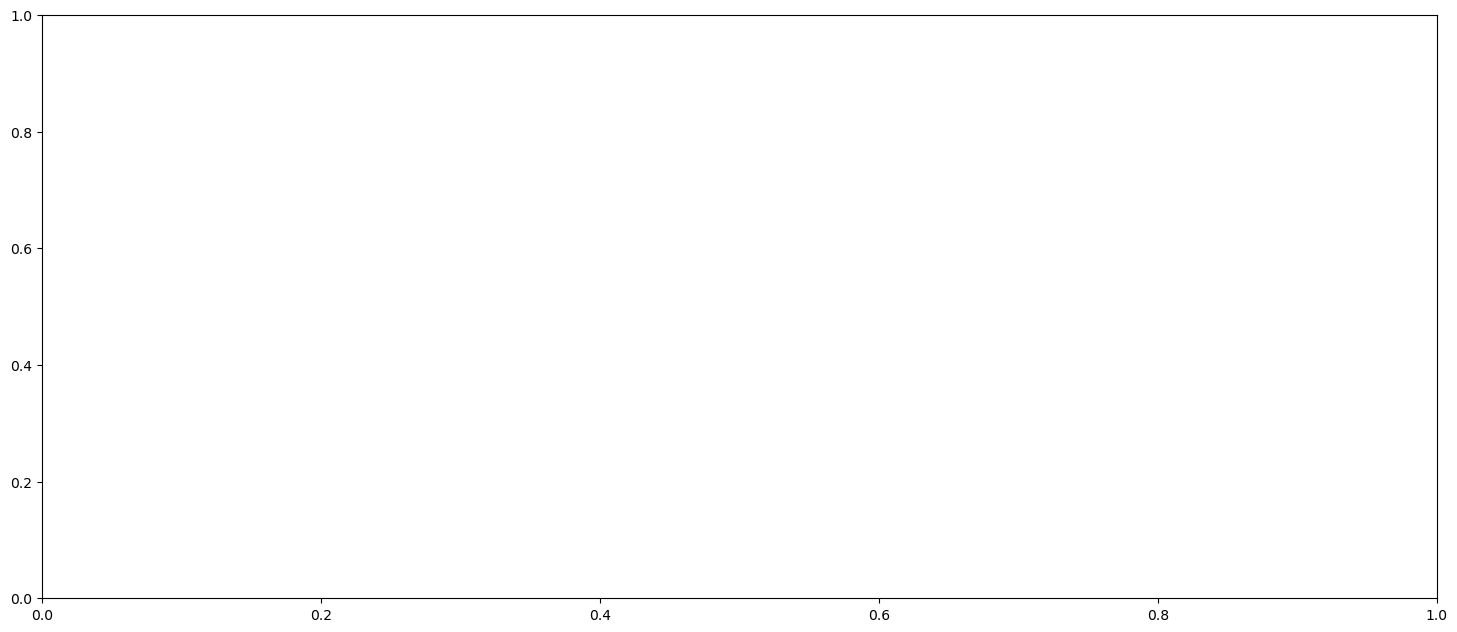

In [ ]:
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(18, 10))

# Create a gridspec with modified height ratios
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 2])

# Create the first subplot
ax0 = plt.subplot(gs[0])

# Assuming layers is a function that plots on the given axes
layers(var, idepth, plot_soil=False, ax=ax0, add_colorbar=False)
ax0.plot(summa.time, summa.scalarSnowDepth, color='k', label='Snow Depth')
ax0.set_ylabel('Depth (m)')
ax0.set_title(f'Snow Depth and Density for Ollalie WY24\nF1={f1:.2f}\nBalanced Accuracy={ba_score:.2f}')


# Create a colormap where 1 is mapped to a color and 0 is mapped to white
cmap = plt.cm.colors.ListedColormap(['white', 'cadetblue'])
bounds = [0,0.5,1]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# Create the second subplot with a modified aspect ratio
ax1 = plt.subplot(gs[1], aspect='auto')

# Plot the DataFrame on the second subplot
cax = ax1.matshow(df_daily_masked_T.values, cmap=cmap, norm=norm, aspect='auto')

# Convert the index to date
dates = df_daily.index.date

# Set the x-axis labels to every 10th date
# ax1.set_xticks(range(0, len(dates), 20))
# ax1.set_xticklabels(dates[::20], rotation=45)  # Rotate labels if they overlap

plt.subplots_adjust(hspace=0.2)  # Increase the value to increase the space between the subplots

ax1.set_xticklabels([])
# Set the y-ticks to the middle of the cells
ax1.set_yticks([0.5, 1.5])

# Set the y-tick labels and shift them up slightly
ax1.set_yticklabels(['SUMMA', 'WSDOT'], verticalalignment='bottom')
ax1.set_title('For December 1 - March 31\nFill=crust, White=no crust')

plt.show()

## Plot just layer density

In [ ]:
out_name = 'salmon_current_WY02'
summa = xr.open_dataset(f'/home/cdalden/summa_setup/model/output/harts_pass/output_harts_current_WY23_timestep.nc')

depth = summa.isel(hru=0)['mLayerHeight']
idepth = summa.isel(hru=0)['iLayerHeight']
frac_wat = summa.isel(hru=0)['mLayerVolFracWat']
temp = summa.isel(hru=0)['mLayerTemp']
# Calculate '-summa['iLayerHeight'].isel(ifcToto=nSnow)'
hs = -summa['iLayerHeight'].isel(ifcToto=nSnow)

In [ ]:
# # plot snow depth and layer density
# # plot = layers(frac_wat, idepth, colormap='viridis', plot_soil=False, plot_snow=True, add_colorbar=True)
# summa['scalarSnowDepth'].plot(color='red', linewidth=2)
# plt.title(out_name+' Density and Snow Depth')
# plt.xlabel('Date')
# plt.ylabel('Snow Depth [m]')
# plt.grid(ls='--', alpha=0.5)

# # plt.savefig('./output/plots/'+out_name+'_layer_density.png', dpi=200)
# # plt.close()
# # ax.set_title(f'Snow Depth and Density for Salmon Meadows (Current) WY02')

## Calculate isothermal days

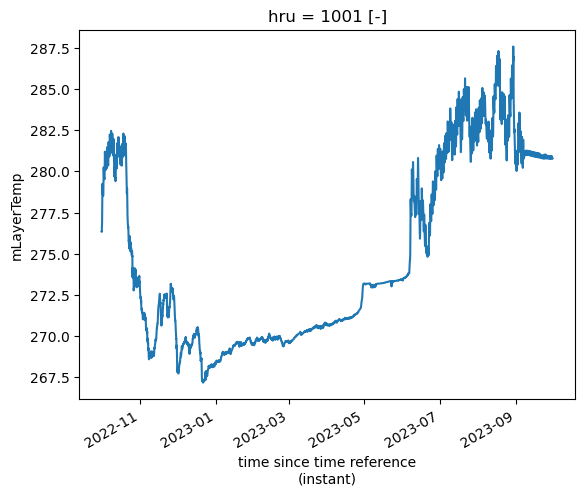

In [ ]:
tmask = temp != -9999
temp.values = justify(temp.where(tmask).values)

# Calculate the average at all layers
average = temp.mean(dim='midToto')

average.plot()

In [ ]:
# Apply the conditions and count the number of timesteps where both conditions are true
isothermal_days = ((hs > 0) & (average > 273.15)).sum().item()

print(isothermal_days/24)

36.708333333333336


## Add new var to netcdf

In [ ]:
crusts = xr.open_dataset('/home/cdalden/summa_setup/analysis/crust_stats.nc')
crusts

<xarray.Dataset>
Dimensions:          (time: 25, model_run: 7, site: 38)
Coordinates:
  * time             (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2024-01-01
  * model_run        (model_run) object 'current' '+1K' '+2K' ... '+5K' '+6K'
  * site             (site) object 'harts' 'salmon' ... 'poperidge'
Data variables:
    mean_crusts      (time, model_run, site) float64 ...
    crust_days       (time, model_run, site) float64 ...
    snow_on          (time, model_run, site) float64 ...
    crusts_binary    (time, model_run, site) float64 ...
    isothermal_days  (time, model_run, site) float64 ...

In [ ]:
summa = xr.open_dataset('/home/cdalden/summa_setup/model/output/output_lonemtn_WY23_timestep.nc')
summa

<xarray.Dataset>
Dimensions:                    (time: 8745, hru: 1, gru: 1, midToto: 109,
                                midSoil: 9, ifcToto: 110)
Coordinates:
  * time                       (time) datetime64[ns] 2022-10-01 ... 2023-09-3...
  * hru                        (hru) int64 1001
  * gru                        (gru) int64 1001
Dimensions without coordinates: midToto, midSoil, ifcToto
Data variables: (12/51)
    pptrate                    (time, hru) float64 ...
    airtemp                    (time, hru) float64 ...
    SWRadAtm                   (time, hru) float64 ...
    LWRadAtm                   (time, hru) float64 ...
    averageInstantRunoff       (time, gru) float64 ...
    averageRoutedRunoff        (time, gru) float64 ...
    ...                         ...
    scalarSoilBaseflow         (time, hru) float64 ...
    scalarAquiferBaseflow      (time, hru) float64 ...
    scalarTotalRunoff          (time, hru) float64 ...
    scalarNetRadiation         (time, hru) float64 ...
    hruId                      (hru) int64 ...
    gruId                      (gru) int64 ...
Attributes: (12/34)
    summaVersion:     v3.1.0
    buildTime:        Thu Sep  8 20:31:59 UTC 2022
    gitBranch:        tags/v3.1.0-0-g372c3fb
    gitHash:          372c3fbeb3825e3b3d635461a8e552f9f0895aec
    soilCatTbl:       ROSETTA
    vegeParTbl:       MODIFIED_IGBP_MODIS_NOAH
    ...               ...
    compaction:       consettl
    thCondSnow:       tyen1965
    thCondSoil:       funcSoilWet
    spatial_gw:       localColumn
    subRouting:       timeDlay
    snowDenNew:       hedAndPom

/tmp/ipykernel_12144/1676804302.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(colormap)


Text(0, 0.5, 'Depth [m]')

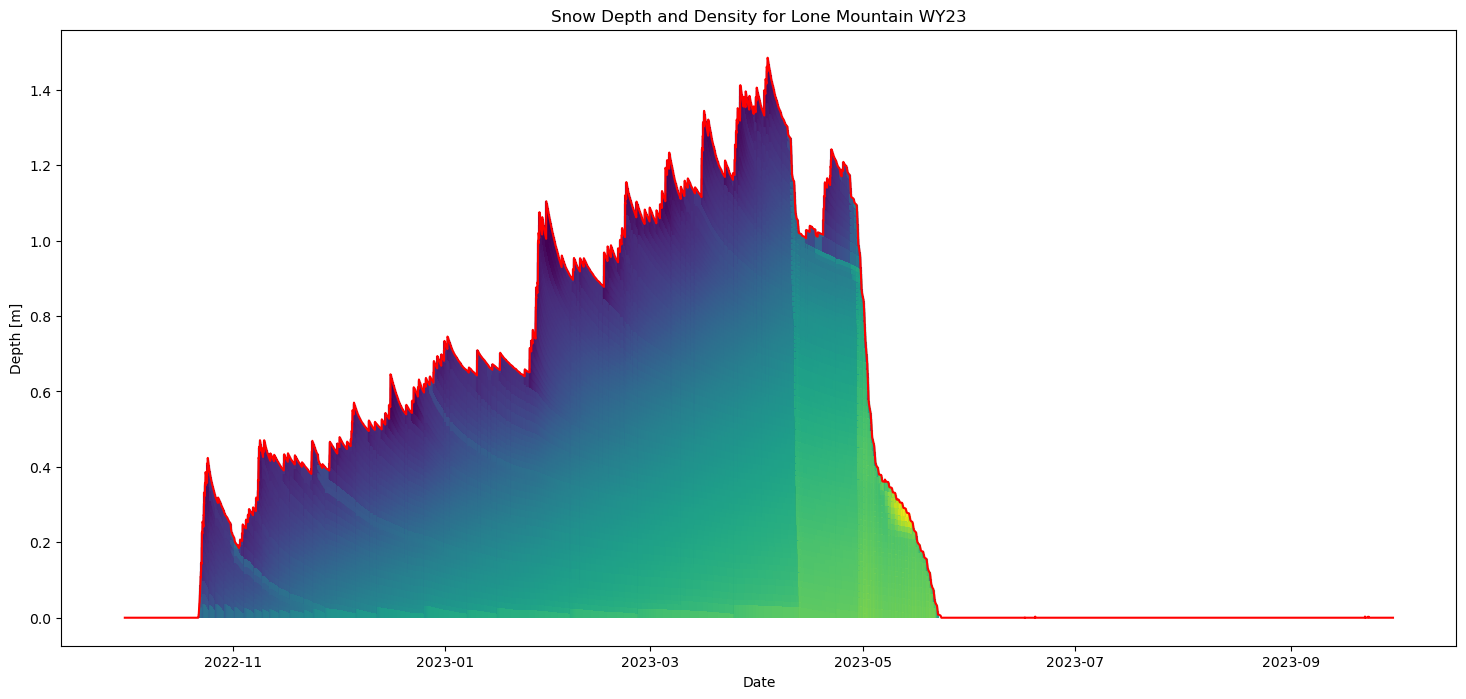

In [ ]:
depth = summa.isel(hru=0)['mLayerHeight']
idepth = summa.isel(hru=0)['iLayerHeight']
var = summa.isel(hru=0)['mLayerVolFracWat']
temp = summa.isel(hru=0)['mLayerTemp']
vmask = var != -9999
dmask = depth != -9999
idmask = idepth != -9999
tmask = temp != -9999
depth.values = justify(depth.where(dmask).values)
idepth.values = justify(idepth.where(idmask).values)
var.values = justify(var.where(vmask).values)
temp.values = justify(temp.where(tmask).values)

fig, ax = plt.subplots(figsize=(18,8))

layers(var, idepth, ax=ax, plot_soil=False, add_colorbar=True)
ax.plot(summa.time, summa.scalarSnowDepth, c='r')
ax.set_title('Snow Depth and Density for Lone Mountain WY23')
ax.set_xlabel('Date')
ax.set_ylabel('Depth [m]')


In [ ]:
import xarray as xr
import numpy as np
data = xr.open_dataset('/home/cdalden/summa_setup/analysis/crust_stats_ski_snotels_vDec9.nc')
# Assuming `data` is your xarray.Dataset
data = data.apply(lambda x: x.where(False, np.nan))

# Now `data` has all variable values set to NaN
data.to_netcdf('/home/cdalden/summa_setup/analysis/crust_stats_ski_snotels_blank.nc')